# 미니 프로젝트 1

## 서울시 공유자전거인 '따릉이'의 수요와 날씨간 연관성 분석하기
- 어떤 날씨요소가 따릉이 수요와 관련 있는지 분석하여 인사이트를 도출해보자.
- 공공데이터 출처
    1. 서울시 공공자전거 시간대별 이용정보 (출처 : 서울시 열린데이터 광장)
    2. 시간별 날씨 자료 (출처 : 기상자료개방포털)

### 데이터 정보
- 기본 데이터 : sbikedata.csv
    1. 기간 : 2021.4~11월 (8개월)
    2. 장소 : 서울시 마포구로 한정
    3. 데이터셋 변수 정보
        * date : 날짜
        * hour : 시간
        * temperature : 온도
        * precipitation : 강우 여부, 비가 오지 않았으면 0, 비가 오면 1
        * windspeed : 풍속(평균)
        * humidity : 습도
        * visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
        * ozone : 오존 수치
        * PM10 : 미세먼지 수치(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
        * PM2.5 : 초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
        * **count : 시간에 따른 따릉이 대여 수(<-Target)**
    

## 1. 데이터 불러오기

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as spst

In [3]:
sbike = pd.read_csv("data/sbikedata.csv")

In [4]:
sbike.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30


In [5]:
sbike['date'] = pd.to_datetime(sbike['date'])
sbike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5827 entries, 0 to 5826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           5827 non-null   datetime64[ns]
 1   hour           5827 non-null   int64         
 2   PM10           5725 non-null   float64       
 3   PM2.5          5732 non-null   float64       
 4   ozone          5699 non-null   float64       
 5   temperature    5827 non-null   float64       
 6   precipitation  5827 non-null   int64         
 7   windspeed      5827 non-null   float64       
 8   humidity       5827 non-null   int64         
 9   visibility     5827 non-null   int64         
 10  count          5827 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 500.9 KB


- 분석단위 : 5827개의 시간대 별 날씨 및 따릉이 대여량 , 11개의 정보

In [6]:
# 결측치 확인
sbike.isna().sum()

date               0
hour               0
PM10             102
PM2.5             95
ozone            128
temperature        0
precipitation      0
windspeed          0
humidity           0
visibility         0
count              0
dtype: int64

- 결측치 처리 방안 : 해당 변수 사용시에만 결측치 빼고 분석

## 2. 가설설정
귀무가설,대립가설이란?
- 귀무가설은 차이가 없다, 연관성이 없다, 효과가 없다.
- 대립가설은 차이가 있다, 연관성이 있다, 효과가 있다.

Target은 따릉이 대여량으로 고정한다.
- 가설1 : 온도와 따릉이 대여량 간에는 연관성이 있다. (비오는 날 제외)
- 가설2 : 습도와 따릉이 대여량 간에는 연관성이 있다. (비오는 날 제외)
- 가설3 : 불쾌지수와 따릉이 대여량 간에는 연관성이 있다.
- 가설4 : 평일/주말과 대여량 간에는 연관성이 있다. (예정)
- 가설5 : 미세먼지 예보와 대여량 간에는 연관성이 있다. (예정)

## 3. 단변량 분석

In [57]:
sbike.describe()

,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,discomfort
count,5827.000000,5725.000000,5732.000000,5699.000000,5827.000000,5827.000000,5827.000000,5827.000000,5827.000000,5827.000000,5827.000000
mean,11.506607,31.970655,15.666609,0.031811,19.376798,0.075511,2.237601,68.608718,1758.438648,215.117899,65.227156
std,6.921963,42.987292,13.850990,0.018277,7.501572,0.264236,1.054516,17.277266,490.969394,185.972900,10.908712
min,0.000000,3.000000,1.000000,0.001000,-3.500000,0.000000,0.000000,19.000000,60.000000,1.000000,32.700250
25%,6.000000,16.000000,7.000000,0.019000,14.100000,0.000000,1.500000,56.000000,1935.500000,53.000000,57.447795
50%,12.000000,25.000000,13.000000,0.031000,20.400000,0.000000,2.200000,70.000000,2000.000000,186.000000,67.190860
75%,18.000000,37.000000,20.000000,0.041000,24.900000,0.000000,2.800000,82.000000,2000.000000,315.000000,73.850455
max,23.000000,827.000000,125.000000,0.137000,36.300000,1.000000,8.300000,100.000000,2000.000000,1746.000000,85.107210


> precipitation 만 범주형! 나머지 다 숫자형

In [7]:
def histbox (x, data, bins = 20):
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    sns.histplot(data[x],kde=True,bins=bins)
    
    plt.subplot(1,2,2)
    sns.boxplot(data[x])
    plt.show()

### Feature1 : hour

In [8]:
sbike['hour'].describe()

count    5827.000000
mean       11.506607
std         6.921963
min         0.000000
25%         6.000000
50%        12.000000
75%        18.000000
max        23.000000
Name: hour, dtype: float64

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


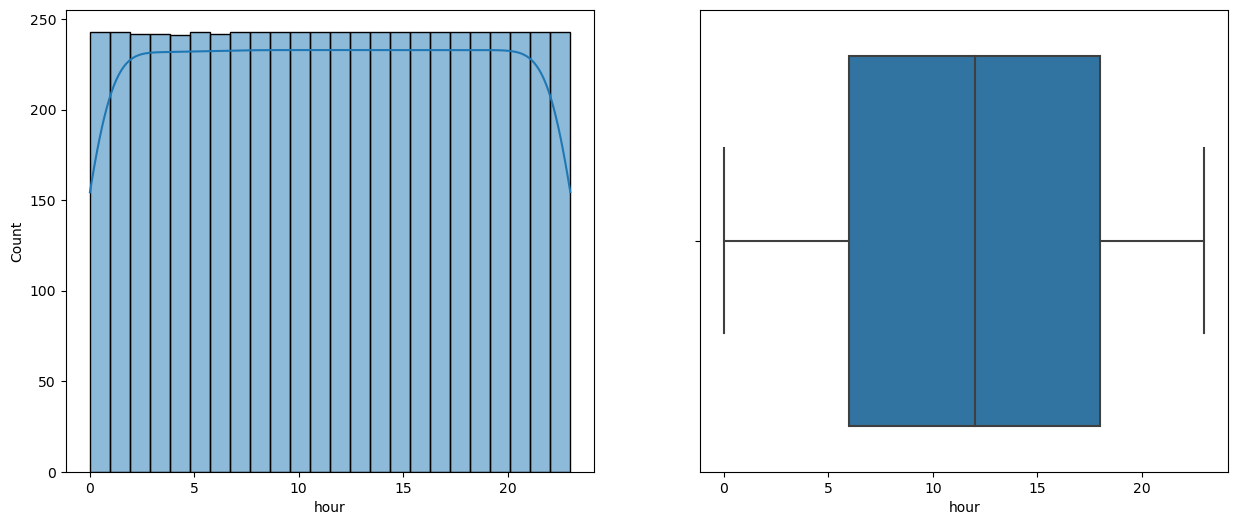

In [9]:
histbox('hour',sbike,bins=24)

### Feature2 : temperature

In [10]:
sbike['temperature'].dtype

dtype('float64')

In [11]:
sbike['temperature'].isna().sum()

0

In [12]:
sbike['temperature'].describe()

count    5827.000000
mean       19.376798
std         7.501572
min        -3.500000
25%        14.100000
50%        20.400000
75%        24.900000
max        36.300000
Name: temperature, dtype: float64

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


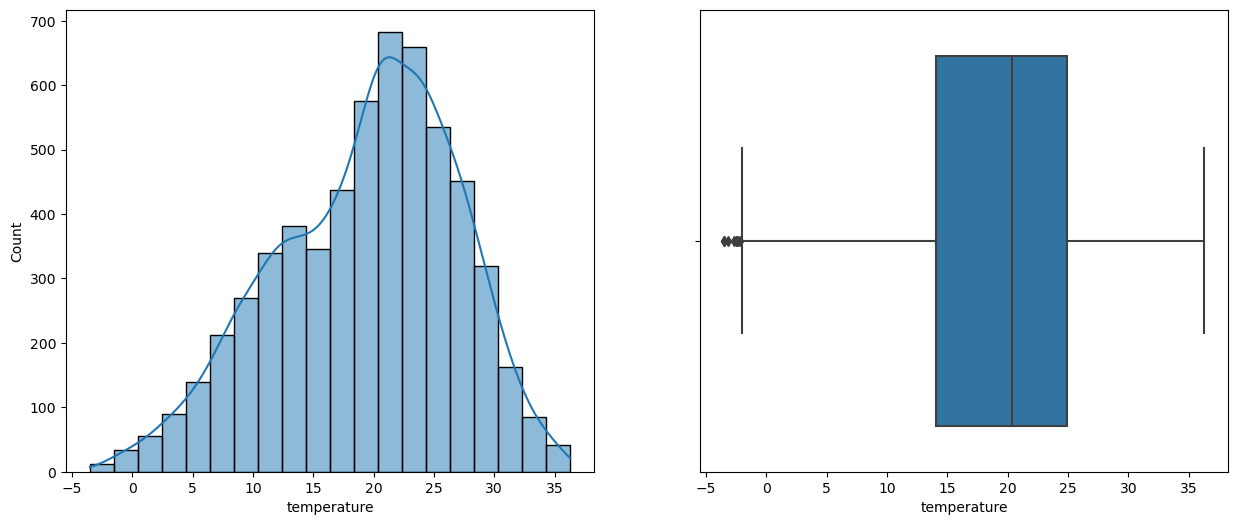

In [13]:
histbox('temperature',sbike)

### Feature3 : precipitation

<AxesSubplot:xlabel='precipitation', ylabel='count'>

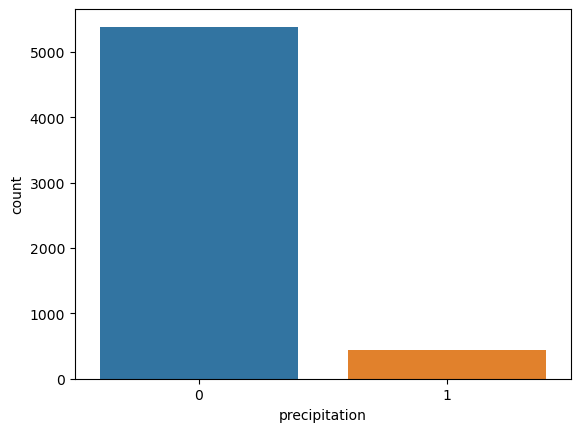

In [14]:
sns.countplot(x = sbike['precipitation'])

In [15]:
#강우 비율 - 7%
sbike['precipitation'].value_counts()/sbike.shape[0]

0    0.924489
1    0.075511
Name: precipitation, dtype: float64

In [16]:
#여름에 강우 비율은?
summer = sbike.loc[sbike['date'].dt.month.isin([6,7,8])]
summer

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
1460,2021-06-01,0,41.0,20.0,0.006,19.8,0,0.9,79,1947,76
1461,2021-06-01,1,40.0,24.0,0.012,19.1,0,2.0,84,1487,58
1462,2021-06-01,2,38.0,24.0,0.020,18.8,0,1.7,84,1757,37
1463,2021-06-01,3,38.0,21.0,0.022,18.8,0,1.6,86,2000,29
1464,2021-06-01,4,38.0,22.0,0.022,18.9,0,1.3,84,2000,24
...,...,...,...,...,...,...,...,...,...,...,...
3663,2021-08-31,19,14.0,10.0,0.030,18.1,1,3.9,98,843,8
3664,2021-08-31,20,12.0,7.0,0.033,18.1,1,4.3,99,438,9
3665,2021-08-31,21,10.0,6.0,0.032,18.1,1,3.8,99,407,6
3666,2021-08-31,22,11.0,5.0,0.029,18.3,1,3.3,100,778,4


<AxesSubplot:xlabel='precipitation', ylabel='count'>

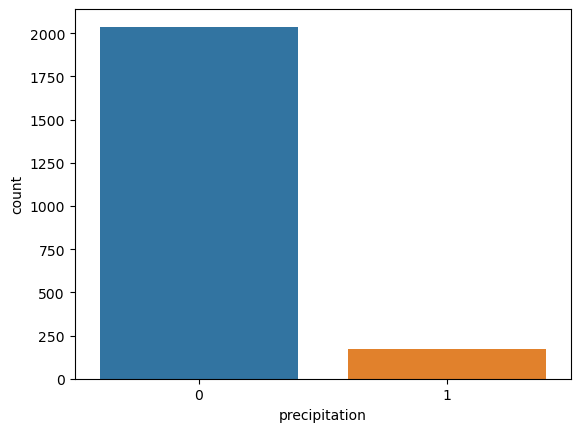

In [17]:
sns.countplot(x = summer['precipitation'])

In [18]:
#여름에 강우 비율 - 약 7% (크게 차이 없음)
summer['precipitation'].value_counts()/summer.shape[0]

0    0.923007
1    0.076993
Name: precipitation, dtype: float64

### Feature4 : windspeed

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


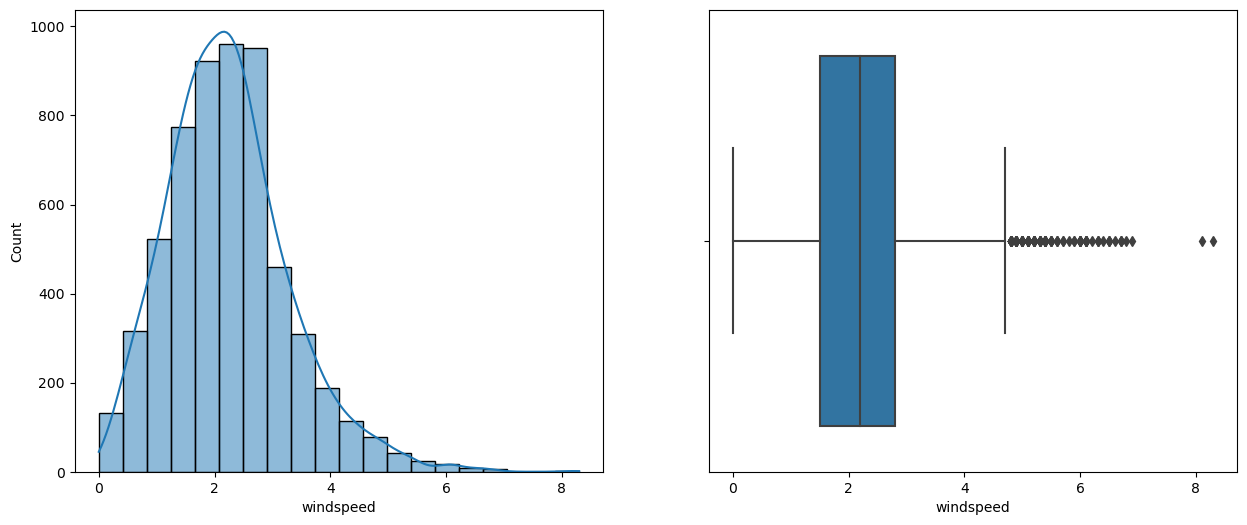

In [19]:
histbox('windspeed',sbike)

### Feature5 : humidity

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


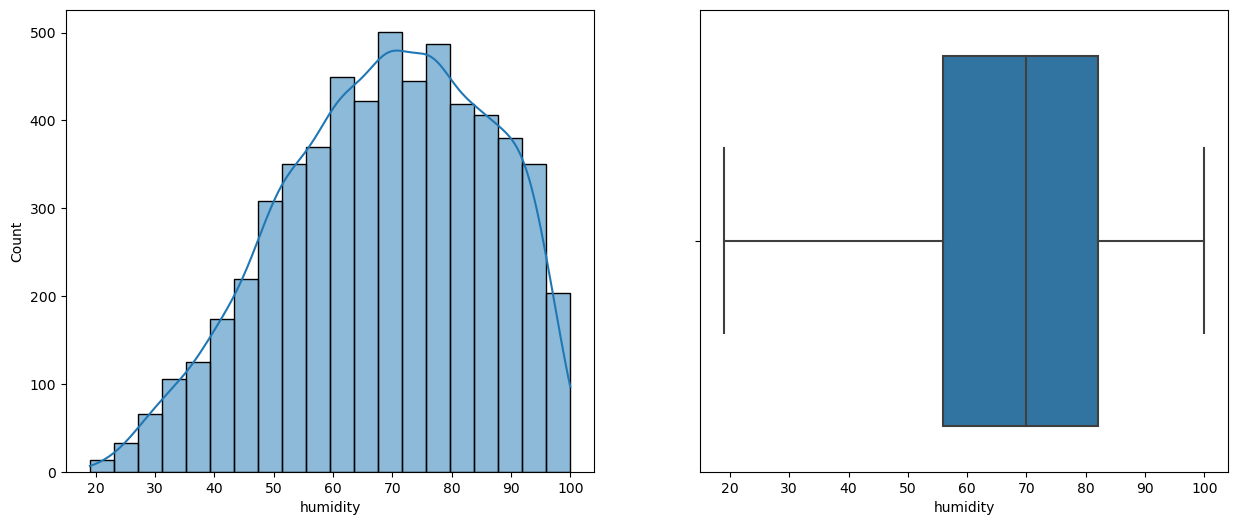

In [20]:
histbox('humidity',sbike)

### Feature6 : visibility

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


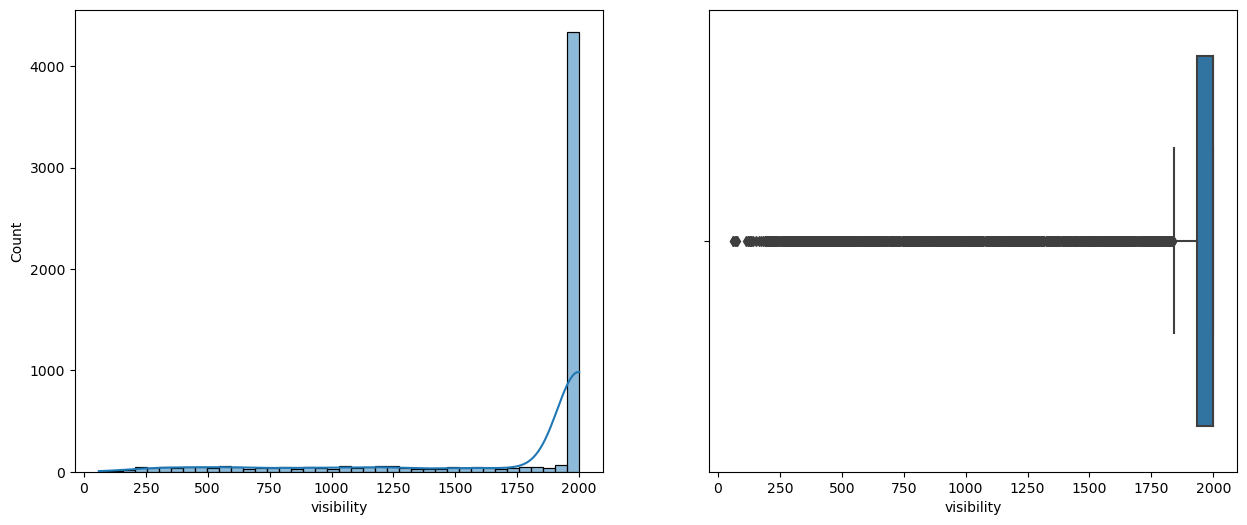

In [21]:
histbox('visibility',sbike,bins=40)

약 2000 에 대부분 몰려있음! -> 실제로 값이 2000이상인 데이터는 모두 2000으로 기재되어있다. 

### Feature7 : ozone

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


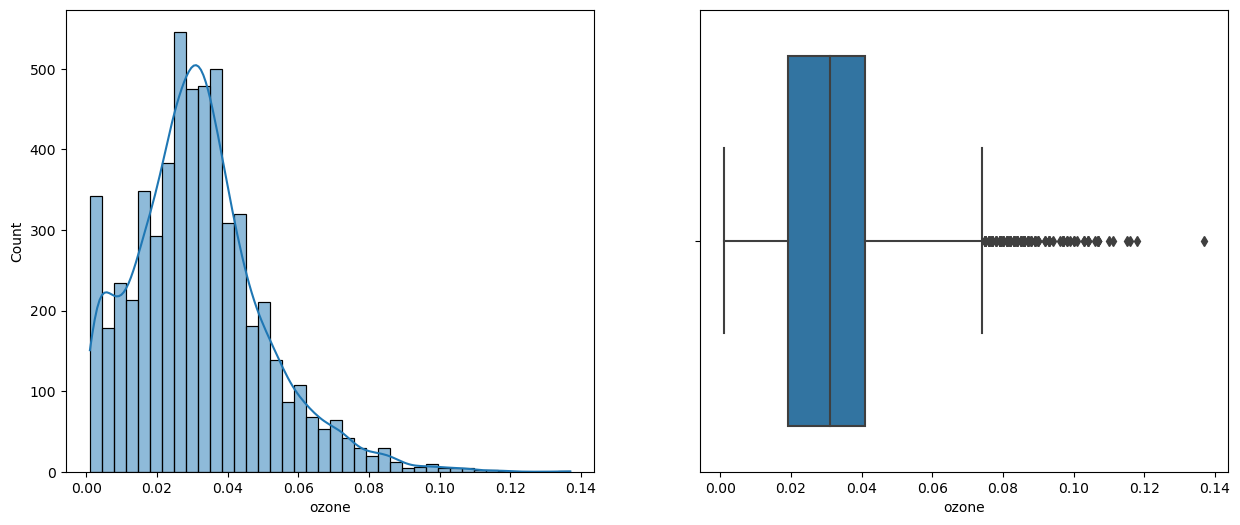

In [22]:
histbox('ozone',sbike,bins=40)

In [23]:
sbike['ozone'].describe()

count    5699.000000
mean        0.031811
std         0.018277
min         0.001000
25%         0.019000
50%         0.031000
75%         0.041000
max         0.137000
Name: ozone, dtype: float64

### Feature8 : PM10

In [24]:
sbike['PM10'].isna().sum()

102

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


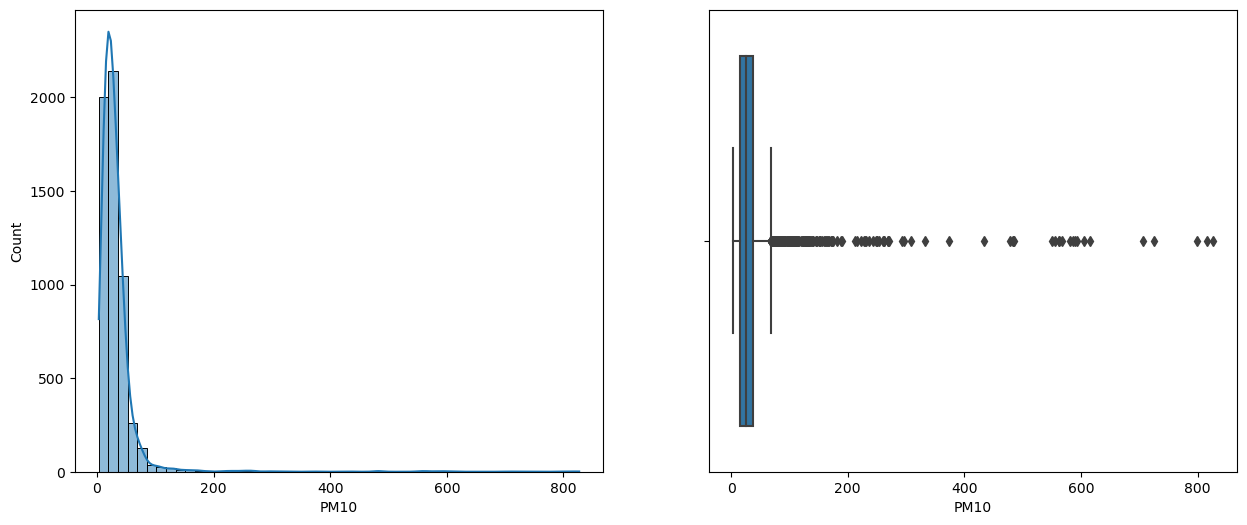

In [25]:
histbox('PM10',sbike,bins=50)

In [26]:
sbike.loc[sbike['PM10'].isnull()]

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
274,2021-04-12,11,NaN,NaN,NaN,16.9,0,2.8,41,2000,117
275,2021-04-12,12,NaN,NaN,NaN,17.6,0,3.9,39,2000,73
276,2021-04-12,13,NaN,NaN,0.038,16.6,0,3.8,48,1974,10
538,2021-04-23,11,NaN,NaN,NaN,20.5,0,4.4,42,2000,261
539,2021-04-23,12,NaN,NaN,NaN,20.6,0,4.4,32,2000,258
...,...,...,...,...,...,...,...,...,...,...,...
5147,2021-11-01,17,NaN,NaN,NaN,14.8,0,2.6,61,2000,525
5503,2021-11-16,13,NaN,NaN,NaN,12.5,0,2.6,36,2000,227
5504,2021-11-16,14,NaN,NaN,NaN,13.3,0,2.9,35,2000,178
5505,2021-11-16,15,NaN,NaN,NaN,13.3,0,3.3,37,2000,233


PM10의 결측치 데이터만 뽑아봤더니 대부분 PM2.5와 오존도 결측치이다.

### Feature9 : PM2.5

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


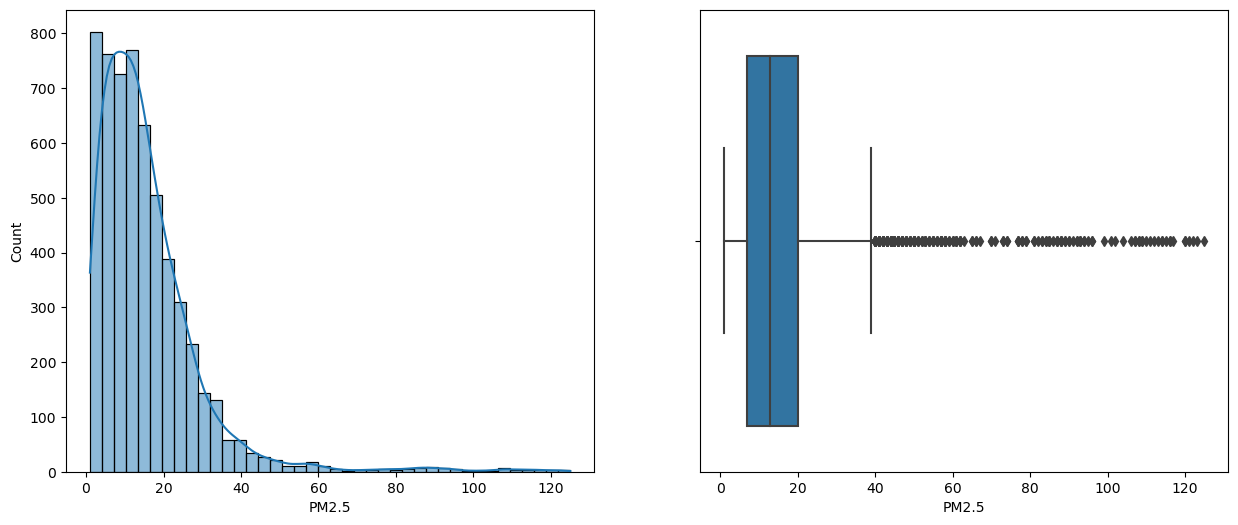

In [27]:
histbox('PM2.5',sbike,bins=40)

### count (Target)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


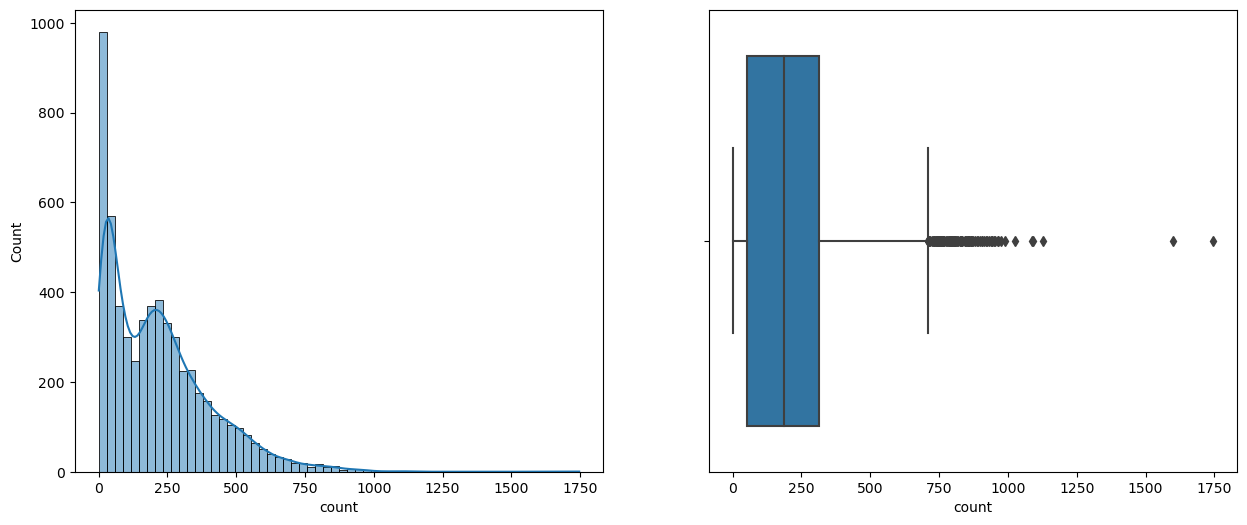

In [28]:
histbox('count',sbike,bins=60)

## 4. 이변량 분석
* 숫자 --> 숫자 : 상관분석
* 범주 --> 범주 : 카이제곱검정
* 범주 --> 숫자 : t검정, 분산분석
* 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.

> 온도,습도,불쾌지수는 모두 숫자형 변수이고, target인 따릉이 대여 count도 숫자형 변수이다.  
따라서 **숫자 -> 숫자 : 상관분석**을 실시하였다.
        
        1. 시각화 : 그래프를 활용한 데이터 분석
        2. 수치화 : 상관분석
        3. 관계 평가 (가설 검정)

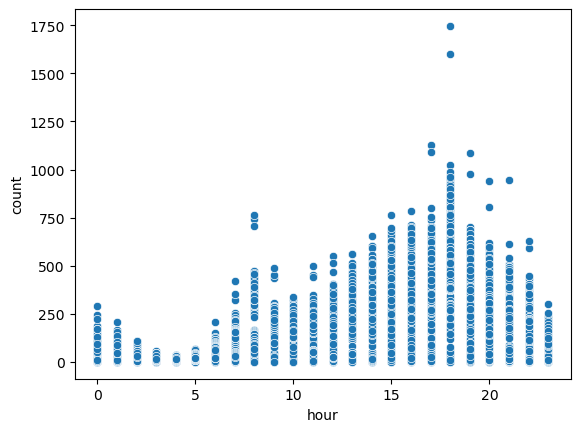

PearsonRResult(statistic=0.5864350283919393, pvalue=0.0)


In [31]:
# 우선 시간대 별 데이터와 따릉이 대여량 간 분석
scatter('hour',y,sbike)

In [34]:
#시간대별 count의 합 -> 17,18,19시 가장 많이 이용 (max=18)
sbike.groupby('hour',as_index=False)['count'].sum()

,hour,count
0,0,22374
1,1,13818
2,2,8562
3,3,5726
4,4,4205
5,5,6859
6,6,16317
7,7,33462
8,8,61533
9,9,45257


> 시간대별 count추이가 다른 변수와의 관계 분석에 영향을 줄 수 있기 때문에 특정 시간대의 데이터만 이용할 것이다.  
**대여량이 가장 많은 시간대인 17,18,19시 데이터만 사용하자.**


### 가설1 : 온도 -> 따릉이 대여량 간의 분석

In [46]:
def scatter (x,y,data) :
    # plt.figure(figsize=(10,6))
    sns.scatterplot(x=x,y=y,data=data)
    plt.show()
    
    print(spst.pearsonr(data[x],data[y]))

def reg (x,y,data) :
    # plt.figure(figsize=(15,6))
    sns.regplot(x=x,y=y,data=data)
    plt.show()
    
    print(spst.pearsonr(data[x],data[y]))

y = 'count'


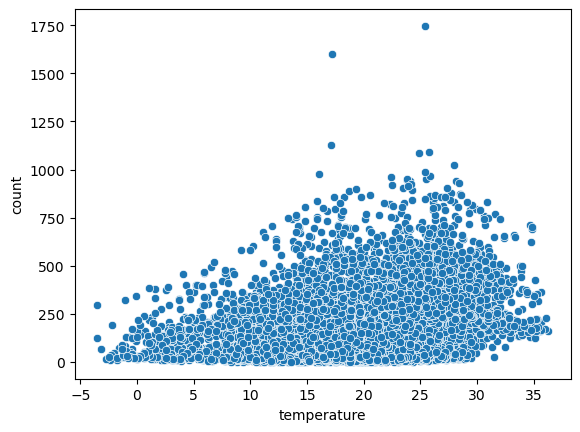

PearsonRResult(statistic=0.2771692363089791, pvalue=2.9405165551619465e-103)


In [47]:
# 시간대 고정 하지 않았을 떄
scatter('temperature',y,sbike)

> 시간대를 고정하지 않으면 같은온도여도 새벽시간이라 count가 적게 찍혀있을 수도 있다. 그러니 반드시 시간을 고정해줘야 한다. 또한 같은 이유로 비가 오지 않은 날의 데이터만 분석한다.

In [48]:
#맑은날, 가장 많이 이용하는 시간대인 17,18,19시 의 온도만 분석
sbike_day = sbike.loc[(sbike['hour'].isin([17.18,19])) & (sbike['precipitation']==0)]
sbike_day

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,discomfort
18,2021-04-01,19,50.0,14.0,0.037,20.6,0,4.6,25,2000,526,64.50950
42,2021-04-02,19,58.0,19.0,0.008,19.9,0,2.3,34,2000,411,64.25534
90,2021-04-04,19,23.0,12.0,0.029,13.6,0,2.4,51,2000,341,56.88964
114,2021-04-05,19,20.0,11.0,0.023,14.4,0,2.7,39,2000,479,57.94684
138,2021-04-06,19,37.0,24.0,0.040,16.0,0,2.5,48,2000,508,59.99920
...,...,...,...,...,...,...,...,...,...,...,...,...
5725,2021-11-25,19,45.0,17.0,0.016,5.9,0,2.1,45,2000,299,47.27245
5749,2021-11-26,19,34.0,17.0,0.011,3.8,0,2.4,69,2000,276,42.10678
5773,2021-11-27,19,40.0,25.0,0.003,4.6,0,2.3,48,2000,171,45.34792
5797,2021-11-28,19,46.0,37.0,0.002,7.0,0,0.3,46,2000,162,48.57980


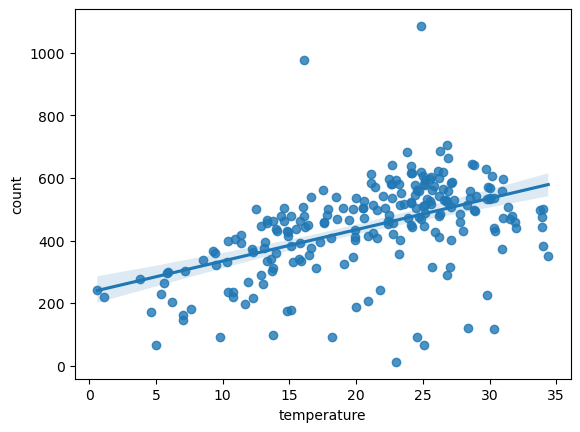

PearsonRResult(statistic=0.4968570009505863, pvalue=1.714182781794795e-15)


In [49]:
reg('temperature',y,sbike_day)

> 온도 -> 따릉이 대여량 : 양의 강한 관계

### 가설2. 습도 -> 따릉이 대여량간 분석

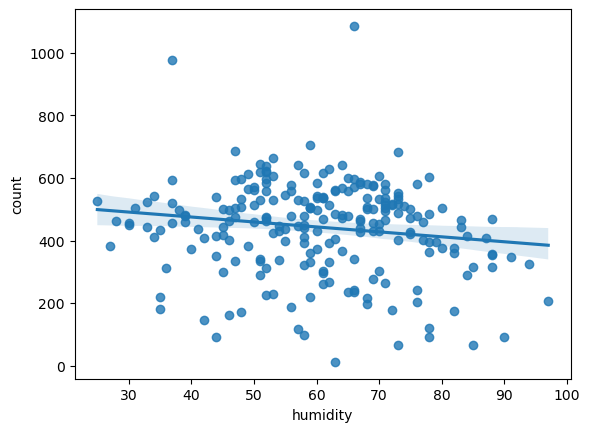

PearsonRResult(statistic=-0.1537663514942156, pvalue=0.020746445524260654)


In [50]:
reg('humidity',y,sbike_day)

> 습도 -> 따릉이 대여량 : 음의 약한 관계

### 가설3. 불쾌지수 -> 따릉이 대여량간 분석
- 온도와 습도의 데이터를 활용하여 불쾌지수를 나타낼 수 있다.
- **불쾌지수 = 1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32**
- 불쾌지수 단계
    - 낮음 : x < 68
    - 보통 : 68 <= x < 75
    - 높음 : 75 <= x < 80
    - 매우높음 : x >= 80

In [44]:
#불쾌지수 행 추가
sbike['discomfort'] = 1.8*sbike['temperature']-0.55*(1-sbike['humidity']*0.01)*(1.8*sbike['temperature']-26)+32
sbike

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,discomfort
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46,56.25881
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40,55.27128
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31,56.33867
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12,56.20080
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30,56.20080
...,...,...,...,...,...,...,...,...,...,...,...,...
5822,2021-11-29,20,74.0,58.0,0.002,9.3,0,0.3,66,1193,273,50.47162
5823,2021-11-29,21,65.0,56.0,0.002,8.4,0,2.0,70,1233,228,48.91520
5824,2021-11-29,22,51.0,41.0,0.002,8.6,0,1.9,70,1250,215,49.21580
5825,2021-11-29,23,43.0,35.0,0.001,8.2,0,2.1,71,1262,125,48.55278


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


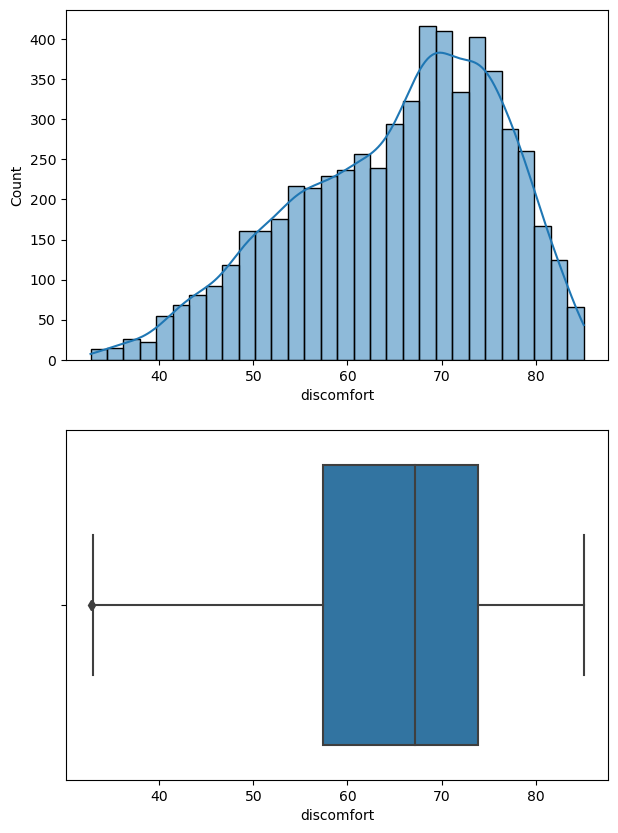

In [52]:
#불쾌지수 단변량 분석
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
sns.histplot(x = 'discomfort',kde=True,data = sbike,bins = 30)
plt.subplot(2,1,2)
sns.boxplot(sbike['discomfort'])

plt.show()

In [53]:
display(sbike[['discomfort']].describe().T)

,count,mean,std,min,25%,50%,75%,max
discomfort,5827.0,65.227156,10.908712,32.70025,57.447795,67.19086,73.850455,85.10721


> 전체 데이터 75%의 불쾌지수 단계가 낮음~보통!

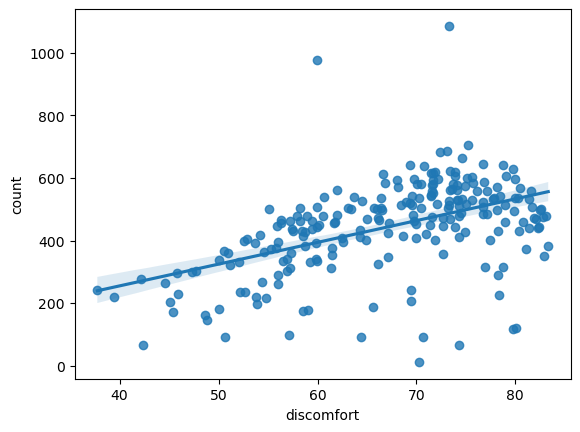

PearsonRResult(statistic=0.4844396316704385, pvalue=1.0600975617205291e-14)


In [59]:
reg('discomfort',y,sbike_day)

> 불쾌지수 -> 따릉이 대여량 : 양의 강한 관계

## 5. 가설 검정
#### 가설1) 온도는 따릉이 대여량과 강한 연관 관계가 있다.
#### 가설2) 습도는 따릉이 대여량과 약한 연관 관계가 있다.
#### 가설3) 불쾌지수는 따릉이 대여량과 강한 연관 관계가 있다.



## 6. 인사이트 도출
- 퇴근시간에 온도가 높고 습도는 낮을수록 대여량은 높아진다. 날씨가 맑고 습도가 낮을 수록 따릉이를 많이 설치해야한다.
- 또한 불쾌지수 단계가 보통(불쾌감을 느낄 수 있는 정도)이상일 때도 자전거 대여량이 많아지는 것을 봤을 때, 불쾌지수가 높을수록 오히려 대중교통보다는 자전거를 이용하여 시원함을 느끼려는 사람들이 있을 것이라는 추측이 가능하다. 따라서 불쾌지수가 높은 날은 따릉이를 지하철역이나 버스 정류장 근처에 더 많이 배치하여 대중교통을 이용하려다가도 따릉이를 이용하도록 유도할 수 있다.